In [1]:
import time
import numpy as np
import util.helper as helper
import util.ts as ts
import util.bernoulli_bandit as bernoulli_bandit
from util.contextual_bandit import ContextualBandit
from util.lin_ucb import LinUCB
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True) 
%matplotlib inline

In [2]:
def get_context():
    context = [[1,1,0,1,0,0],
               [1,1,0,0,1,0],
               [1,1,0,0,0,1],
               [1,0,1,1,0,0],
               [1,0,1,0,1,0],
               [1,0,1,0,0,1]]
    cid = np.random.choice([0,1,2,3,4,5])
    x = np.array(context[cid]).reshape(-1,1)
    return cid, x

payouts = [[0.25,0.30,0.20],
           [0.20,0.30,0.25],
           [0.20,0.30,0.25],
           [0.30,0.20,0.25],
           [0.30,0.25,0.20],
           [0.25,0.20,0.30]]

## LinUCB algorithm
<img src="img/linucb.jpeg" style="text-align:center; width:50%">

Source: L. Li, W. Chu, J. Langford, and R. E. Schapire. <a href="https://arxiv.org/pdf/1003.0146.pdf">A contextual-bandit approach to personalized
news article recommendation</a>. In Proceedings of the 19th international conference on World
wide web, pages 661–670, 2010.

## Simulation setup & encoding

<img src="img/sim_setup.png" style="text-align:center; width:60%">

<img src="img/encoding.png" style="text-align:center; width:70%">

##  Use the first visitor to show how to compute UCB values, choose an arm and update matrices after receiving the reward.
### Print the initialized As & bs

In [3]:
lin_ucb = LinUCB(n_arms=3, dim=6, alpha=2)
cmab = ContextualBandit(n_arms=3, payouts=payouts, sample_size=100)  

for arm in range(lin_ucb.n_arms):
    print("A{}:\n{}\n".format(arm, lin_ucb.A[arm]))
print()  
for arm in range(lin_ucb.n_arms):
    print("b{}:\n{}\n".format(arm, lin_ucb.b[arm]))

A0:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

A1:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

A2:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


b0:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

b1:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

b2:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]



### Generate 1st visitor and its context feature vector $x_{t}$

In [4]:
np.random.seed(2000)
context_id, x = get_context()
print(x)

[[1]
 [1]
 [0]
 [1]
 [0]
 [0]]


### Compute the UCB value for each arm based on 1st visitor's context feature vector $x_{t}$ at the time step $t = 0$
$\hat{\theta}_{a} \leftarrow A^{-1}_{a}  b_{a}$
  
$\mu_{a} \leftarrow \hat{\theta}^T_{a}  x_{t}$

$\sigma_{a} \leftarrow \sqrt{x_{t}^T A_{a}^{-1} x_{t}}$  
  
$ucb_{a} \leftarrow \mu_{a} + \alpha * \sigma_{a}$        
$\alpha$ is a hyperparameter.

In [5]:
ucbs = []
means = []

# Arm 0
Ainv = np.linalg.inv(lin_ucb.A[0])
theta = np.dot(Ainv, lin_ucb.b[0])
mu = np.dot(theta.T, x)
sigma = np.sqrt(np.dot(np.dot(x.T, Ainv), x))
ucb = mu + lin_ucb.alpha * sigma
means.append(mu)
ucbs.append(ucb[0][0])
print("Arm 0:\n")
print("A:\n {}\n".format(lin_ucb.A[0]))
print("x:\n {}\n".format(x))
print("Ainv:\n {}\n".format(Ainv))
print("theta:\n {}\n".format(theta))
print("mu:\n {}\n".format(mu))
print("sigma:\n {}\n".format(sigma))
print("Arm 0 ucb: {}".format(ucbs[0]))

Arm 0:

A:
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

x:
 [[1]
 [1]
 [0]
 [1]
 [0]
 [0]]

Ainv:
 [[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [-0. -0. -0.  1. -0. -0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]

theta:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

mu:
 [[0.]]

sigma:
 [[1.73205081]]

Arm 0 ucb: 3.4641016151377544


In [6]:
np.random.seed(2000)
ucbs = []
means = []

# Arm 0
Ainv = np.linalg.inv(lin_ucb.A[0])
theta = np.dot(Ainv, lin_ucb.b[0])
mu = np.dot(theta.T, x)
sigma = np.sqrt(np.dot(np.dot(x.T, Ainv), x))
ucb = mu + lin_ucb.alpha * sigma
means.append(mu)
ucbs.append(ucb[0][0])
print("Arm 0 ucb: {}".format(ucbs[0]))

# Arm 1
Ainv = np.linalg.inv(lin_ucb.A[1])
theta = np.dot(Ainv, lin_ucb.b[1])
mu = np.dot(theta.T, x)
sigma = np.sqrt(np.dot(np.dot(x.T, Ainv), x))
ucb = mu + lin_ucb.alpha * sigma
means.append(mu)
ucbs.append(ucb[0][0])
print("Arm 1 ucb: {}".format(ucbs[1]))

# Arm 2
Ainv = np.linalg.inv(lin_ucb.A[2])
theta = np.dot(Ainv, lin_ucb.b[2])
mu = np.dot(theta.T, x)
sigma = np.sqrt(np.dot(np.dot(x.T, Ainv), x))
ucb = mu + lin_ucb.alpha * sigma
means.append(mu)
ucbs.append(ucb[0][0])
print("Arm 2 ucb: {}".format(ucbs[2]))

action = np.random.choice(np.where(ucbs == np.max(ucbs))[0])
print("Action(Arm chosen): {}".format(action))

Arm 0 ucb: 3.4641016151377544
Arm 1 ucb: 3.4641016151377544
Arm 2 ucb: 3.4641016151377544
Action(Arm chosen): 2


### Update A & b for the chosen arm $a_{t}$ based on $x_{t}$ and reward  $r_{t}$
$A_{a_{t}} \leftarrow A_{a_{t}} + x_{t} x^{T}_{t}$  
$b_{a_{t}} \leftarrow b_{a_{t}} + r_{t} x_{t}$

In [8]:
np.linalg.inv(xxt)

LinAlgError: Singular matrix

In [7]:
# generate reward
#np.random.seed(2021) #=> get reward 0
np.random.seed(2020) #=> get reward 1
reward = cmab.pull_arm(action, context_id)
print("Reward: {}\n".format(reward))

# update A
print("A before update:\n{}\n".format(lin_ucb.A[action]))
xxt = np.dot(x, np.transpose(x))
lin_ucb.A[action] += xxt
print("X*XT:\n{}\n".format(xxt))
print("A after update:\n{}\n".format(lin_ucb.A[action]))

print("b before update:\n{}\n".format(lin_ucb.b[action]))
rx = reward*x
lin_ucb.b[action] += rx
print("Reward*X:\n{}\n".format(rx))
print("b after update:\n{}\n".format(lin_ucb.b[action]))

Reward: 1

A before update:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

X*XT:
[[1 1 0 1 0 0]
 [1 1 0 1 0 0]
 [0 0 0 0 0 0]
 [1 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

A after update:
[[2. 1. 0. 1. 0. 0.]
 [1. 2. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

b before update:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Reward*X:
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]]

b after update:
[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]



### Use the built-in functions to choose an arm and update matrices.

In [8]:
np.random.seed(2000)
lin_ucb = LinUCB(n_arms=3, dim=6, alpha=2)
cmab = ContextualBandit(n_arms=3, payouts=payouts, sample_size=100)
# Choose an arm based on UCBs
action, ucbs = lin_ucb.choose_arm(x)
# Get reward
reward = cmab.pull_arm(action, context_id)
# Update A & b
lin_ucb.update(action, reward, x)
print(action, reward)

2 1


## Full Simulation

In [9]:
np.random.seed(2000)
start_time = time.time()

n_samples = 100000
n_simulations = 100
ct_bandits, ts_bandits, co_bandits = [], [], []
for k in range(n_simulations):
    lin_ucb = LinUCB(n_arms=3, dim=6, alpha=2)
    ct_bandit = ContextualBandit(n_arms=3, payouts=payouts, sample_size=n_samples)
    ts_bandit = ContextualBandit(n_arms=3, payouts=payouts, sample_size=n_samples)
    co_bandit = ContextualBandit(n_arms=3, payouts=payouts, sample_size=n_samples)
    for i in range(n_samples):
        context_id, x = get_context()
        
        # CMAB
        action, ucbs = lin_ucb.choose_arm(x)
        reward = ct_bandit.pull_arm(action, context_id)
        lin_ucb.update(action, reward, x)
        
        # MAB
        action = ts.sample(ts_bandit.arm_S+1, ts_bandit.arm_F+1)['action']
        ts_bandit.pull_arm(action, context_id)
        
        # Control
        co_bandit.pull_arm(0, context_id)
        
    ct_bandits.append(ct_bandit)
    ts_bandits.append(ts_bandit)
    co_bandits.append(co_bandit) 
    
    if (k+1)%10 == 0:
        print("finish run {}!".format(k+1))
helper.print_elapsed_time(start_time)

finish run 10!
finish run 20!
finish run 30!
finish run 40!
finish run 50!
finish run 60!
finish run 70!
finish run 80!
finish run 90!
finish run 100!
[Start time]:2020-06-17 10:24:53
[End time]:2020-06-17 10:56:56
[Elapsed time]:0:32:03.209390


LinUCB: 0.2975, TS-MAB: 0.2567, CONTROL: 0.2502


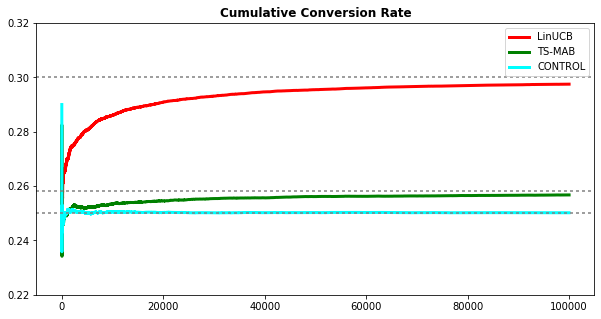

In [17]:
import warnings
warnings.filterwarnings("ignore")
cvr_ct = bernoulli_bandit.get_avg_per_period_reward(ct_bandits)
cvr_ts = bernoulli_bandit.get_avg_per_period_reward(ts_bandits)
cvr_co = bernoulli_bandit.get_avg_per_period_reward(co_bandits)

plt.figure(figsize=(10,5))
plt.plot(cvr_ct, color='red', linewidth=3, label='LinUCB')
plt.plot(cvr_ts, color='green', linewidth=3, label='TS-MAB')
plt.plot(cvr_co, color='cyan', linewidth=3, label='CONTROL')
plt.axhline(0.30,linestyle='--',color='grey', dashes=(2, 2))
plt.axhline(0.2583,linestyle='--',color='grey', dashes=(2, 2))
plt.axhline(0.25,linestyle='--',color='grey', dashes=(2, 2))
plt.title('Cumulative Conversion Rate', fontweight="bold")
print("LinUCB: {:.4f}, TS-MAB: {:.4f}, CONTROL: {:.4f}".format(cvr_ct[-1], cvr_ts[-1], cvr_co[-1]))
plt.ylim([0.22,0.32])
plt.legend()